In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style(name='/custom3.css')

# Unscented Kalman Filters

* The nonlinearity can appear in two places: measurents and the process model.
    * Measurements: A radar, measuring the slant range to an object, takes a square root to compute the x,y coordinates:$$x=\sqrt{slant^2 - altitude^2}$$
> Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflects some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object.

    * The process model: Track a ball traveling through the air, where the effects of gravity and air drag lead to highly nonlinear behavior.

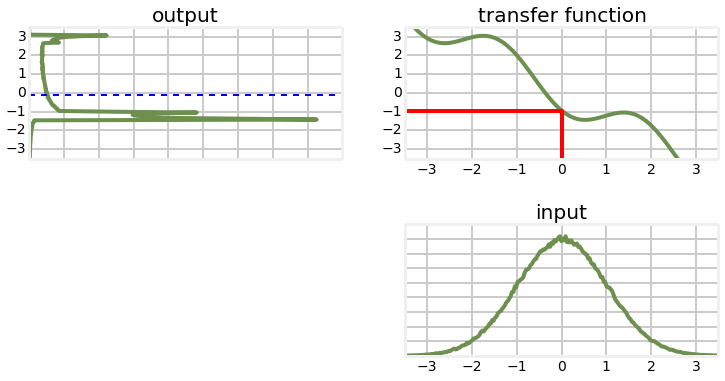

In [2]:
from numpy.random import normal
import numpy as np

data = normal(loc=0.0, scale=1, size=500000)

def plot_transfer_func(data, f, lims, num_bins=1000):
    ys = f(data)
        
    h = np.histogram(ys, num_bins, density=False)
   
    #plot output
    plt.subplot(2,2,1)
    plt.plot(h[0], h[1][1:], lw=4)
    plt.ylim(lims)
    plt.gca().xaxis.set_ticklabels([])
    plt.title('output')

    plt.axhline(np.mean(ys), ls='--', lw=2)

    # plot transfer function
    plt.subplot(2,2,2)
    x = np.arange(lims[0], lims[1],0.1)
    y = f(x)
    plt.plot (x,y)
    isct = f(0)
    plt.plot([0,0,lims[0]],[lims[0],isct,isct],c='r')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title('transfer function')

    # plot input
    h = np.histogram(data, num_bins, density=True)

    plt.subplot(2,2,4)
    plt.plot(h[1][1:], h[0], lw=4)
    plt.xlim(lims)
    plt.gca().yaxis.set_ticklabels([])
    plt.title('input')

    plt.show()


def g(x):
    return (np.cos(4*(x/2+0.7)))-1.3*x

plot_transfer_func (data, g, lims=(-3.5,3.5), num_bins=300)

* Generated by taking 500,000 samples from the input, passing it through the nonlinear transform, and building a histogram of the result.
* From the output histogram we can compute a mean and standard deviation which would give us an updated, approximated Gaussian.
* It implies that this sampling process constitutes a solution to our problem. 
    * Suppose for every update we generated 500,000 points, passed them through the function, and then computed the mean and variance of the result. 
        * This is called a 'Monte Carlo' approach, and it used by some filter designs, such as the *Particle filter*, *Ensemble filter*. 
    * No matter how nonlinear or poorly behaved the function is, as long as we sample with enough points we will build an accurate output distribution.

* "Enough points" is the key. 
    * The graph above was created with 500,000 points, and the output is still not smooth.
    * Getting a reasonable estimate of the mean and variance does not need to use that many points
    * In general, the number of points required increases by the power of the number of dimensions. 
        * If you only needed $50$ points for 1 dimension, you'd need $50^2=2,500$ for two dimensions, $50^3=125,000$ for three dimensions, and so on.
* The **Unscented Kalman filter** uses a similar technique but reduces the amount of computation needed by a drastic amount by using a deterministic method of choosing the points.

## Choosing Sigma Points

* Let's look at the problem in terms of a 2D covariance ellipse. 
* Assuming some arbitrary nonlinear function, we will take random points from the covariance ellipse, pass them through the nonlinear function, and plot their new position.

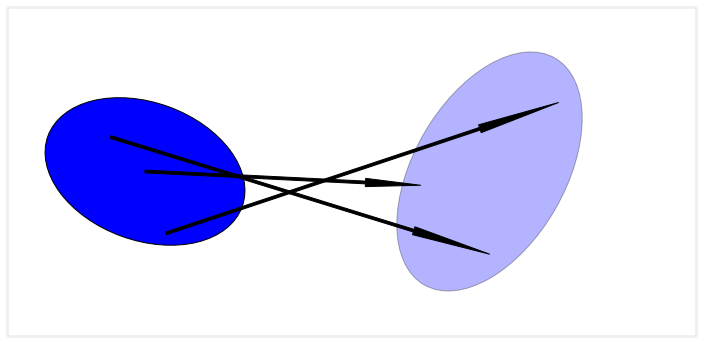

In [3]:
from matplotlib.patches import Ellipse,Arrow
import numpy as np

def arrow(x1,y1,x2,y2, width=0.2):
    return Arrow(x1,y1, x2-x1, y2-y1, lw=1, width=width, ec='k', color='k')


ax=plt.gca()

ax.add_artist(Ellipse(xy=(2,5), width=2, height=3,angle=70,linewidth=1,ec='k'))
ax.add_artist(Ellipse(xy=(7,5), width=2.2, alpha=0.3, height=3.8,angle=150,linewidth=1,ec='k'))

ax.add_artist(arrow(2, 5, 6, 4.8))

ax.add_artist(arrow(1.5, 5.5, 7, 3.8))
ax.add_artist(arrow(2.3, 4.1, 8, 6))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.axis('equal')
plt.xlim(0,10); plt.ylim(0,10)
plt.show()


* The left shows an ellipse depicting the $1\sigma$ distribution of two state variables.
* The arrows show how three randomly sampled points might be transformed by some arbitrary nonlinear function to a new distribution. 
* The ellipse on the right is an *estimate* of the mean and variance of this collection of points 
    * If we were to sample, say, a million points the shape of the points might be very far from an ellipse. 

Let's look at that by running a bunch of points through a nonlinear function. 

$$\begin{aligned}x^-&=x+y\\
y^- &= 0.1x^2 + y^2\end{aligned}$$ 

for the mean and covariance $$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

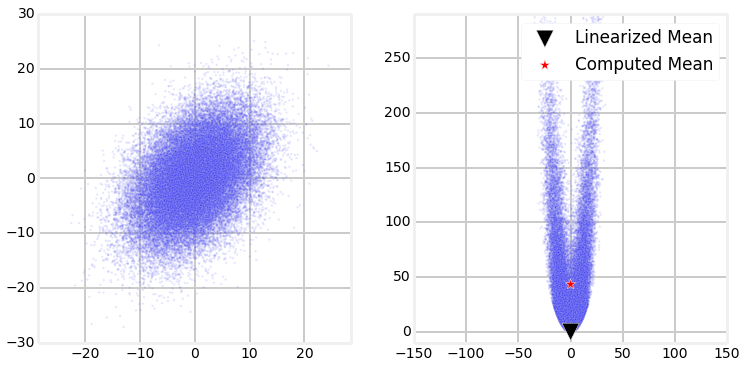

Difference in mean x=-0.069, y=43.364


In [4]:
from numpy.random import randn
import numpy as np
from numpy import sin, cos, tan,log
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal


def f(x,y):
    return x+y, .1*x**2 +y*y

mean = (0, 0)
p = np.array([[32, 15],[15., 40.]])

xs ,ys = multivariate_normal(mean=mean, cov=p, size=50000).T
fxs, fys = [], []
for x,y in zip(xs,ys):
    fx, fy = f(x,y)
    
    fxs.append(fx)
    fys.append(fy)

# Compute mean
mean_fx = f(*mean)

computed_mean_x = np.average(fxs)
computed_mean_y = np.average(fys)

plt.subplot(121)
plt.scatter (xs,ys, marker='.', alpha=0.1)
plt.axis('equal')

plt.subplot(122)
plt.scatter(fxs, fys, marker='.', alpha=0.1)
plt.scatter(mean_fx[0], mean_fx[1], 
            marker='v', s=300,c='k', label='Linearized Mean')
plt.scatter(computed_mean_x, computed_mean_y, 
            marker='*',s=120,c='r', label='Computed Mean')
plt.ylim([-10,290])
plt.xlim([-150,150])
plt.legend(loc='best', scatterpoints=1)
plt.show()
print ('Difference in mean x={:.3f}, y={:.3f}'.format(
       computed_mean_x-mean_fx[0], computed_mean_y-mean_fx[1]))

* This plot shows the strong nonlinearity that occurs with this function, and the large error that would result if we linearized the function at (0,0), which is what filters like the Extended Kalman filters do.

* While the computed mean is quite accurate with 50,000 points, computing 50,000 points for every update would cause our filter to be very slow.
* What would be fewest number of sampled points that we can use
* What kinds of constraints does this problem formulation put on the points?

Let's consider the simplest possible case and see if it offers any insight. 
* The simplest possible system is *identity* - the transformation does not alter the input. 
    * In mathematical notation this is just $f(x) = x$. 
* The fewest number of points that we can use is one per dimension. 
    * This is the number that the linear Kalman filter uses. 
    * The input to a Kalman filter for the distribution $\mathcal{N}(\mu,\sigma^2)$ is just $\mu$ itself.
    * If we were to pass some value $\mu+\Delta$ into the identity function $f(x)=x$ it would not converge, so this is not a possible algorithm.

So, what is the next lowest number we can choose? 
* Consider the fact that Gaussians are symmetric
    * The next lowest number is 3 points. 3 points allows us to select the mean, and then one point on each side of the mean, as depicted on the chart below.

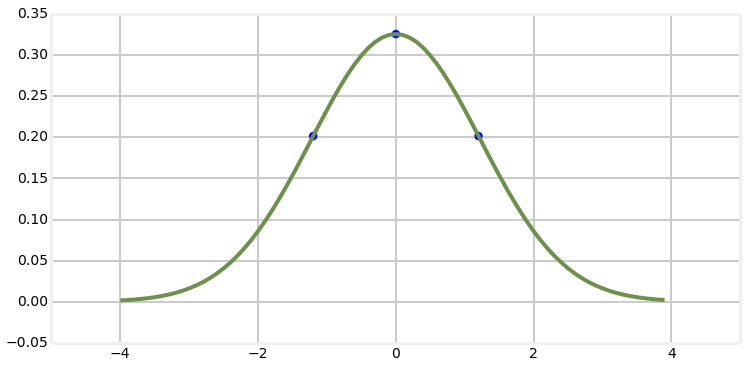

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import stats

xs = np.arange(-4, 4, 0.1)
var = 1.5
ys = [stats.gaussian(x, 0, var) for x in xs]
samples = [0, 1.2, -1.2]
for x in samples:
    plt.scatter ([x], [stats.gaussian(x, 0, var)], s=80)

plt.plot(xs, ys)
plt.show()

* For this to work for identity we will want the sums of the weights to equal one.
    * If the sum is greater or less than one the sampling will not yield the correct output. 
* Given that, we then have to select *sigma points* $\mathcal{X}$ and their corresponding weights so that they compute to the mean and variance of the input Gaussian.

$$\begin{aligned}
1 &= \sum_i{w_i}\;\;\;&(1) \\
\mu &= \sum_i w_i\mathcal{X}_i\;\;\;&(2) \\
\Sigma &= \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}\;\;\;&(3)
\end{aligned}
$$

* There is no one unique answer - the problem is unconstrained. 
    * For example, if you choose a smaller weight for the point at the mean for the input, you could compensate by choosing larger weights for the rest of the $\mathcal{X}$.
    * These equations do not require that any of the points be the mean of the input at all, though it seems 'nice' to do so.

* We are choosing 3 points for each dimension in our covariances. 
* That choice is *entirely deterministic*. 

Below are three different examples for the same covariance ellipse.

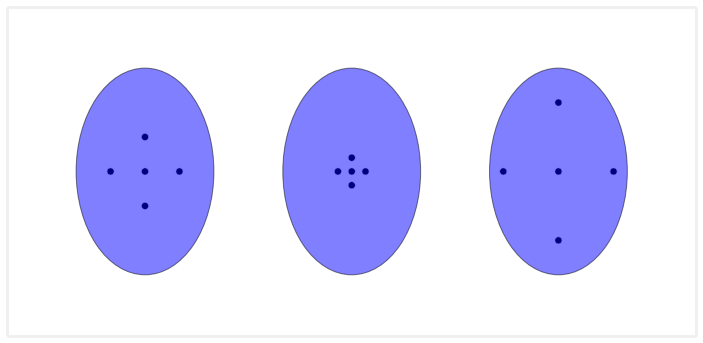

In [6]:
from matplotlib.patches import Ellipse,Arrow
import numpy as np

ax=plt.gca()
ax.add_artist(Ellipse(xy=(2,5), alpha=0.5, width=2, height=3,angle=0,linewidth=1,ec='k'))
ax.add_artist(Ellipse(xy=(5,5), alpha=0.5, width=2, height=3,angle=0,linewidth=1,ec='k'))
ax.add_artist(Ellipse(xy=(8,5), alpha=0.5, width=2, height=3,angle=0,linewidth=1,ec='k'))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.scatter([1.5,2,2.5],[5,5,5],c='k', s=50)
plt.scatter([2,2],[4.5, 5.5],c='k', s=50)

plt.scatter([4.8,5,5.2],[5,5,5],c='k', s=50)
plt.scatter([5,5],[4.8, 5.2],c='k', s=50)

plt.scatter([7.2,8,8.8],[5,5,5],c='k', s=50)
plt.scatter([8,8],[4,6],c='k' ,s=50)

plt.axis('equal')
plt.xlim(0,10); plt.ylim(0,10)
plt.show()


* The constraints above do not require the points lieing along the major and minor axis of the ellipse; however, it is fairly typical to do this.
* Furthermore, in each case the points evenly spaced; again, the constraints above do not require that. 
    * It is a reasonable choice, after all; if we want to accurately sample our input it makes sense to sample in a symmetric manner.
* There are several published ways for selecting the sigma points. 
    * For now we will stick with the original implementation by Julier and Uhlmann, which defines a constant $\kappa$ which controls how to spread out the sigma points.
    > Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

Plot the sigma points on top of a covariance ellipse showing the first and second deviations, and size them based on the weights assigned to them. 

$$\mathbf{P} = \begin{bmatrix} 4&2\\2&4\end{bmatrix}$$

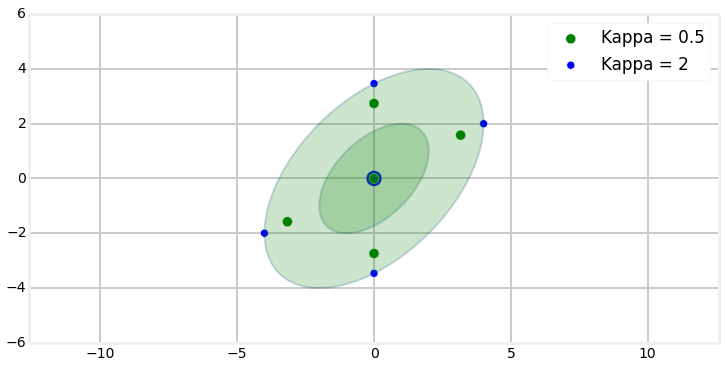

In [7]:
from numpy import array
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import plot_covariance_ellipse

x = array([0, 0])
P = array([[4, 2],
           [2, 4]])

sigmas_kp5 = UKF.sigma_points(x=x, P=P, kappa=0.5)
sigmas_k2 = UKF.sigma_points(x=x, P=P, kappa=2)
Wp5 = UKF.weights(2, kappa=0.5)
W2 = UKF.weights(2, kappa=2)

for i in range(len(Wp5)):
    p2 = plt.scatter(sigmas_k2[i,0], sigmas_k2[i,1], s=W2[i]*500, c='b')
    p1 = plt.scatter(sigmas_kp5[i,0], sigmas_kp5[i,1], s=Wp5[i]*500, c='g')

plt.legend([p1, p2], ['Kappa = 0.5', 'Kappa = 2'])
plot_covariance_ellipse(x, P, facecolor='g', alpha=0.2, std=[1,2])

* The sigma points lie between the first and second deviation, and that the larger $\kappa$ spreads the points out further.
* The larger $\kappa$ weighs the mean (center point) higher than the smaller $\kappa$, and weighs the rest of the sigma points less.
    * This should fit our intuition - the further a point is from the mean the less we should weight it.

## Handling the Nonlinearities

* There are two places for nonlinearities to occur: 
    * The state transition function
    * The measurement function
    
* The linear Kalman filter
    * Uses the equation
$$ \bf{x}^-=\bf{Fx}$$
to propagate the state from one epoch to the next. 
        * F defines a set of linear equations that performs this calculation.

    * Uses the measurement function in this equation
$$\hat{\bf{x}} = \bf{K}(\bf{z-Hx}^-)$$
to incorporate the measurements into the state. 
        * $\bf{Hx}$ converts $\bf{x}$ to a measurement using the linear equations implied by $\bf{H}$.

* The UKF assumes that both the measurement function and state transition function are nonlinear, though in some problems only one is nonlinear.
    * Define a function $h(x)$ for the measurement function and $f(x)$ for the state transition function.
    

    def hx(x):
        z = # do something to compute z
        return z
        
    def fx(x, dt):
        x_est = x propagated forward in time by dt
        return x_est

## Sigma Point Algorithm

* The first sigma point is the mean of input, $\mathcal{X}_0$.
$$ \mathcal{X}_0 = \mu$$
The corresponding weight for this sigma point is
$$ W_0 = \frac{\kappa}{n+\kappa} $$
where $n$ is the dimension of the problem, and $\kappa$ is a scaling factor.

* The rest of the sigma points are defined to be
$$ 
\begin{aligned}
\mathcal{X}_i &= \mu + (\sqrt{(n+\kappa)\Sigma})_i\,\,\, \text{for}\text{ i=1 .. n} \\
\mathcal{X}_i &= \mu - (\sqrt{(n+\kappa)\Sigma})_{i-n}\,\,\, \text{for}\text{ i=(n+1) .. 2n} \\
\text{and the corresponding weights are} \\
W_i &= \frac{1}{2(n+\kappa)}\,\text{for i=1,2..2n}
\end{aligned}
$$

* $\kappa$ is a scaling factor that controls how far away from the mean the points spread out.
    * A larger $\kappa$ will choose points further away from the mean, and a smaller $\kappa$ will choose points nearer the mean. 
* Julier and Uhlmann suggest using $\kappa + n = 3$ if the distribution is Gaussian, and perhaps choosing a different value if it is not Gaussian. 
    * It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems.
    * We are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to 1 standard deviation. 
    * There is an $n$ term in there - the more dimensions there are the more the points will be spread out and weighed less.

## The Unscented Transform

* The unscented transform is the core of the algorithm.
* Given a set of sigma points and a transfer function we need to compute the **new mean and covariance** of the points after they have passed through the function. 
    * Loop through the sigma points and compute their new position after passing through your nonlinear function. 
    * Compute the mean and covariance of these points.


$$\begin{aligned}
\mu &= \sum_i w_i\mathcal{X}_i\;\;\;&(2) \\
\Sigma &= \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}\;\;\;&(3)
\end{aligned}
$$

## The Unscented Filter

* Assume that there is a function $f(x, dt)$ that performs the state transition.
    * It predicts the next state given the current state.
* Assume there is a measurement function $h(x)$.
    * It takes the current state and computes what measurement that state corresponds to.

### Predict Step

* As with the linear Kalman filter, the UKF's predict step computes the mean and covariance of the system for the next epoch using the process model.

* First, generate the weights and sigma points as specified above.

$$\begin{aligned}
\mathcal{X} &= sigma\_function(\bf{x}, \bf{P}) \\
W &= weight\_function(n, \kappa)\end{aligned}$$

* Pass each sigma point through the function f.
    * This projects the sigma points forward in time according to the process model.

$$\mathcal{X_f} = f(\mathcal{X})$$

* Compute the predicted mean and covariance using the *unscented transform *on the transformed sigma points.

$$\begin{aligned}
\mathbf{x}^- &= \sum W\mathcal{X_f} \\
\mathbf{P}^- &= \sum W{(\mathcal{X_f}-\bf{x}^-)(\mathcal{X_f}-\bf{x}^-)^\mathsf{T}} + \mathbf{Q}
\end{aligned}
$$

This computes the mean and covariance represented by the green ellipse below, and corresponds with the linear Kalman filter equations of
$$ \begin{aligned}
\mathbf{x}^- &= \mathbf{Fx}\\
\mathbf{P}^- &= \mathbf{FPF}^T+\mathbf{Q}
\end{aligned}$$

Graphically, this looks something like this
* The arrows show the effect of passing the sigma points through the nonlinear function*f(x)*
* The green ellipse is the new mean and covariance calculated by the unscented transform

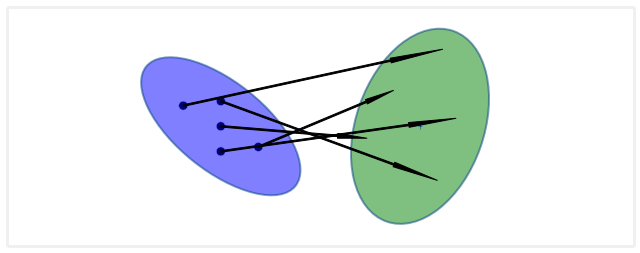

In [8]:
with book_format.figsize(10,4):
    fig = plt.figure()
    ax=fig.gca()

    x = np.array([0, 5])
    P = np.array([[4, -2.2], [-2.2, 3]])

    plot_covariance_ellipse(x, P, facecolor='b', variance=9, alpha=0.5)
    S = UKF.sigma_points(x=x, P=P, kappa=0)
    plt.scatter(S[:,0], S[:,1], c='k', s=80)

    x = np.array([15, 5])
    P = np.array([[3, 1.2],[1.2, 6]])
    plot_covariance_ellipse(x, P, facecolor='g', variance=9, alpha=0.5)


    ax.add_artist(arrow(S[0,0], S[0,1], 11, 4.1, 0.6))
    ax.add_artist(arrow(S[1,0], S[1,1], 13, 7.7, 0.6))
    ax.add_artist(arrow(S[2,0], S[2,1], 16.3, 0.93, 0.6))
    ax.add_artist(arrow(S[3,0], S[3,1], 16.7, 10.8, 0.6))
    ax.add_artist(arrow(S[4,0], S[4,1], 17.7, 5.6, 0.6))

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    #plt.axis('equal')
    plt.show()

### Update Step

* Convert the sigma points from the predict step into measurements using the $h(x)$ function.

$$\mathcal{X_z} = h(\mathcal{X})$$

* Compute the mean and covariance of these points using the unscented transform.
$$\begin{aligned}
\mathbf{x}_z &= \sum w\mathcal{X_z} \\
\mathbf{P}_z &= \sum w{(\mathcal{X_z}-x)(\mathcal{X_z}-x)^\mathsf{T}} + \mathbf{R}
\end{aligned}
$$
The $z$ subscript denotes that these are the mean and covariance for the measurements.

* Compute the residual and Kalman gain.
    
$$ \mathbf{y} = \mathbf{z} - \mathbf{x}_z$$

$$\mathbf{P}_{xz} =\sum W(\mathcal{X}-x)(\mathcal{X_z}-\mathbf{x}_z)^\mathsf{T}$$

$$K = \mathbf{P}_{xz} \mathbf{P}_z^{-1}$$

* Compute the new state estimate using the residual and Kalman gain.

$$\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

* Comupute the new covariance.

$$ \mathbf{P} = \mathbf{P}^- - \mathbf{KP}_z\mathbf{K}^\mathsf{T}$$

### Comparing the KF equations with the UKF equations

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
\mathbf{\bar{x}} = \mathbf{Fx} & \mathbf{\bar{\mu}} = \sum w\boldsymbol{\mathcal{X_f}} \\
\mathbf{\bar{P}} = \mathbf{FPF}^\mathsf{T}+\mathbf{Q}  & \mathbf{\bar{\Sigma}} = \sum w({\boldsymbol{\mathcal{X_f}}-\bf{\bar{\mu}})(\boldsymbol{\mathcal{X_f}}-\bf{\bar{\mu}})^\mathsf{T}} + \mathbf{Q} \\
\hline 
\mathbf{y} = \boldsymbol{\mathbf{z}} - \mathbf{H\bar{x}}  &
\mathbf{y} = \mathbf{z} - \sum w \boldsymbol{\mathcal{X_z}}\\
\mathbf{S} = \mathbf{H\bar{P}H}^\mathsf{T} + \mathbf{R} & 
\mathbf{P}_z = \sum w{(\boldsymbol{\mathcal{X_z}}-\mu_z)(\boldsymbol{\mathcal{X_z}}-\mu_z)^\mathsf{T}} + \mathbf{R} \\ 
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} \mathbf{S}^{-1} &
\mathbf{K} = \left[\sum w(\boldsymbol{\chi_f}-\bar{\mu})(\boldsymbol{\mathcal{X_z}}-\mathbf{\mu}_z)^\mathsf{T}\right] \mathbf{P}_z^{-1}\\
\mathbf{x} = \mathbf{\bar{x}} + \mathbf{Ky} & \mathbf{x} = \mathbf{\bar{\mu}} + \mathbf{Ky}\\
\mathbf{P} = (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf{P} = \mathbf{\bar{\Sigma}} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$


$$\boldsymbol{\mathcal{X_f}} = f(\boldsymbol{\chi})$$
$$\boldsymbol{\mathcal{X_z}} = h(\boldsymbol{\mathcal{X_f}})$$
$$\mathbf{{\mu}_z} = \sum w\boldsymbol{\mathcal{X_z}}$$

## Using the UKF

* Although the UKF was designed for nonlinear problems, it works fine on linear problems.
* Write a solver for the linear problem of tracking using a constant velocity model in 2D. 

* First, design a linear Kalman filter with $\bf{x}$, $\bf{F}$, $\bf{H}$, $\bf{R}$, and $\bf{Q}$ matrices. 
    * Define $\bf{x}$ to be
$$ \mathbf{x} = \begin{bmatrix}x \\  \dot{x} \\ y \\ \dot{y} \end{bmatrix}$$.
    
    * Define our state transition model to be
$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$
which implements the Newtonian equation
$$x_k = x_{k-1} + \dot{x}_{k-1}\Delta t$$
    
    * The measurement function is
$$\mathbf{H} = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

    * Assume a measurement noise matrix of 
$$\mathbf{R} = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$
    
    * Assume that the process noise is discrete white noise model
$$\mathbf{Q} = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

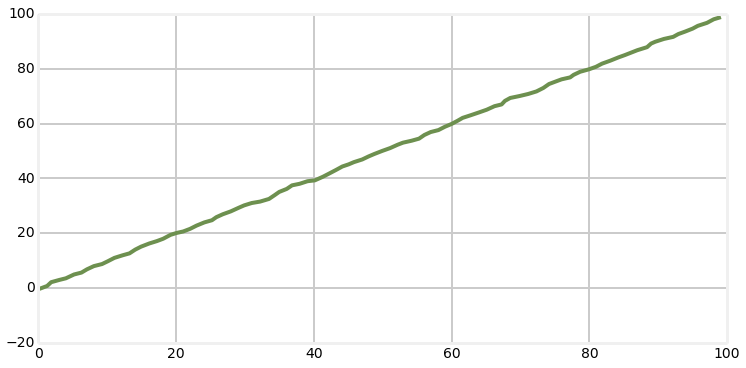

In [9]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy import random

dt = 1.0

random.seed(1234)
kf = KalmanFilter(4,2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([0.09, 0.09])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1,0,0,0],
                 [0,0,1,0]])
 
kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)
xs = []
zs = [] # save the zs so we use the same data for the UKF
for i in range(100):
    z = np.array([i+randn()*0.3, i+randn()*0.3])
    kf.predict()
    kf.update(z)
    xs.append(kf.x)
    zs.append(z)
    
xs = np.asarray(xs)
plt.plot(xs[:,0], xs[:,2])
plt.show()

* Now implement this filter as an Unscented Kalman filter.
    > This is purely for educational purposes; using a UKF for a linear filter confers no benefit.
    * Specify the matrices and the nonlinear functions *f(x)* and *h(x)*. 
        * *f(x)* implements the state transition function that is implemented by the matrix $\mathbf{F}$ in the linear filter
        * *h(x)* implements the measurement function implemented with the matrix $\mathbf{H}$.

* For our linear problem we can just define these functions to implement the linear equations. 
    * The function *f(x)* takes the signature `def f(x,dt)`
    * *h(x)* takes the signature `def h(x)`.

In [10]:
def f_cv(x, dt):
    """ state transition function for a constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return np.dot(F, x)

def h_cv(x):
    return np.array([x[0], x[2]])

* Other than these two functions, everything else is nearly the same. 

In [11]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, kappa=0)

* The rest of the code is the same as for the linear kalman filter. 
    * Use the same measurements as used by the linear Kalman filter, and compute the standard deviation of the difference between the two solution.

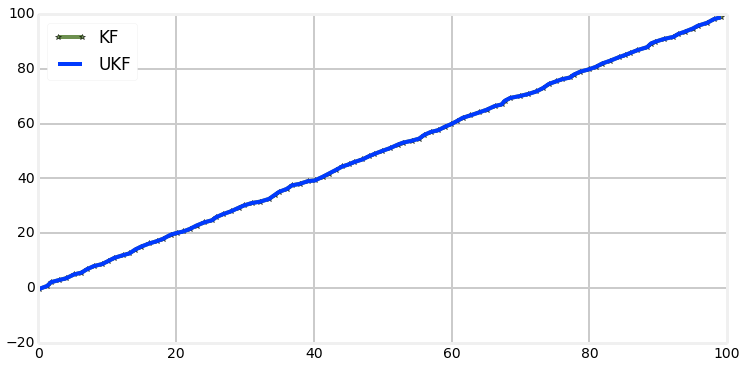

UKF standard deviation 0.013


In [12]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, kappa=0)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)
uxs = []
for i,z in enumerate(zs):
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    
uxs = np.asarray(uxs)
plt.plot(xs[:,0], xs[:,2], marker='*', label='KF')
plt.plot(uxs[:,0], uxs[:,2], label='UKF')
plt.legend(loc='best')
plt.show()
print('UKF standard deviation {:.3f}'.format(np.std(uxs-xs)))

* There is not much difference in the implementation of the UKF vs linear Kalman filter.
    * We merely replace $\mathbf{F}$ with the function *f(x)*, and the matrix $\mathbf{H}$ with the function *h(x)*. 
    * The rest of the theory and implementation remains the same. 

## Tracking a Flying Airplane

### First Attempt

* Write a filter to track a flying airplane in two dimensions using a stationary radar as the sensor.
    * Track one dimension on the ground and the altitude of the aircraft.
    * Take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft

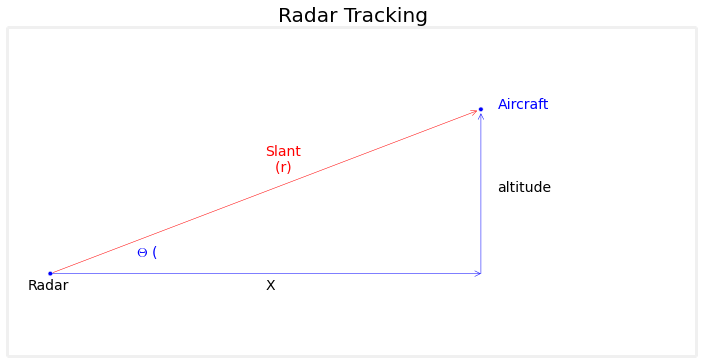

In [13]:
import matplotlib.pyplot as plt

plt.xlim([0.9,2.5])
plt.ylim([0.5,2.5])

plt.scatter ([1,2],[1,2])

ax = plt.axes()
ax.annotate('', xy=(2,2), xytext=(1,1),
            arrowprops=dict(arrowstyle='->', ec='r',shrinkA=3, shrinkB=4))
ax.annotate('', xy=(2,1), xytext=(1,1),
            arrowprops=dict(arrowstyle='->', ec='b',shrinkA=0, shrinkB=0))
ax.annotate('', xy=(2,2), xytext=(2,1),
            arrowprops=dict(arrowstyle='->', ec='b',shrinkA=0, shrinkB=4))
ax.annotate('$\Theta$ (', xy=(1.2, 1.1), color='b')
ax.annotate('Aircraft', xy=(2.04,2.), color='b')
ax.annotate('altitude', xy=(2.04,1.5), color='k')
ax.annotate('X', xy=(1.5, .9))
ax.annotate('Radar', xy=(.95, 0.9))
ax.annotate('Slant\n  (r)', xy=(1.5,1.62), color='r')

plt.title("Radar Tracking")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.show()

* Assume that the aircraft is flying at a constant altitude, so a three variable state vector will work.

$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude\end{bmatrix}=  \begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix}$$

* The state transition function is linear 

$$\mathbf{x}^- = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} 
$$

In [14]:
def f_radar(x, dt):
    """ state transition function for a constant velocity aircraft
    with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return np.dot(F, x)

* Design the measurement function, converting the filter's state into a measurement, the bearing and range from the radar station.
    * Represent the position of the radar station with an (x,y) coordinate computation of the range and bearing is straightforward. 
$$range = \sqrt{(x_{ac} - x_{radar})^2 + (z_{ac} - z_{radar})^2}$$
    * To compute the bearing we need to use the arctangent function.
$$bearing = \tan^{-1}{\frac{z_{ac} - z_{radar}}{x_{ac} - x_{radar}}}$$

In [15]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dz = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    bearing = math.atan2(dz, dx)
    return slant_range, bearing

h_radar.radar_pos = (0,0)

* Simulate the Radar station and the movement of the aircraft.

In [16]:
from numpy.linalg import norm
from math import atan2

class RadarStation(object):
    
    def __init__(self, pos, range_std, bearing_std):
        self.pos = np.asarray(pos)
        
        self.range_std = range_std
        self.bearing_std = bearing_std

    
    def reading_of(self, ac_pos):
        """ Returns actual range and bearing to aircraft as tuple. 
        Bearing is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and bearing to aircraft with simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.bearing_std 
        return rng, brg
        
   
class ACSim(object):
    
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std
        
        
    def update(self, dt):
        """ compute next position. Incorporates random variation in
        velocity. Returns new position."""
        
        vel = self.vel*dt + (randn() * self.vel_std)*dt      
        self.pos += vel
        
        return self.pos

* Assume 5m range accuracy, and 0.5$^\circ$ angular accuracy, starting with the aircraft positioned directly over the radar station, flying away from it at 100 m/s. 
* A typical radar might update only once every 12 seconds and so we will use that for our update period. 

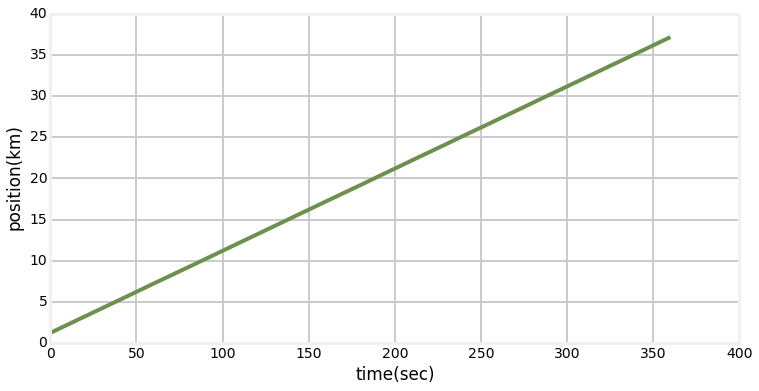

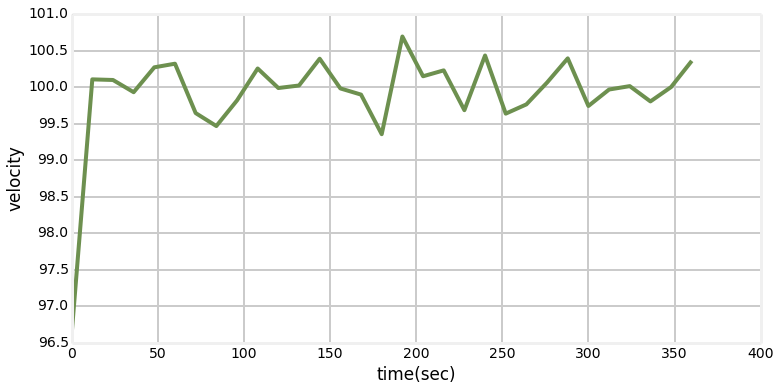

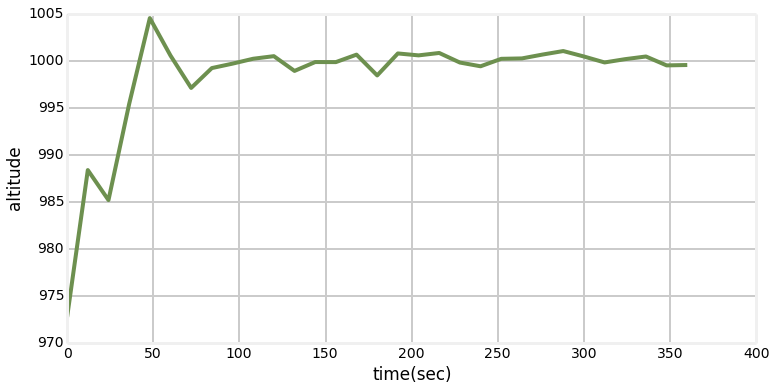

In [17]:
import math

from filterpy.common import Q_discrete_white_noise

dt = 12. # 12 seconds between readings

range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])


radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)
ac = ACSim(ac_pos, (100,0), 0.02)

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)
   
def plot_radar(xs, t, plot_x=True, plot_vel=True, plot_alt=True):
    
    xs = np.asarray(xs)
    if plot_x:
        plt.figure()
        plt.plot(t, xs[:,0]/1000.)
        plt.xlabel('time(sec)')
        plt.ylabel('position(km)')
        
    if plot_vel:
        plt.figure()
        plt.plot(t, xs[:,1])
        plt.xlabel('time(sec)')
        plt.ylabel('velocity')

    if plot_alt:
        plt.figure()
        plt.plot(t, xs[:,2])
        plt.xlabel('time(sec)')
        plt.ylabel('altitude')
        plt.show()
    
plot_radar(xs, t)

### Tracking Maneuvering Aircraft

* The previous example produced extremely good results, but it also relied on an assumption of an aircraft flying at a constant speed with no change in altitude. 
* Next, relax that assumption by allowing the aircraft to change altitude.
    * First, let's see the performance of the previous code if the aircraft starts climbing after one minute.

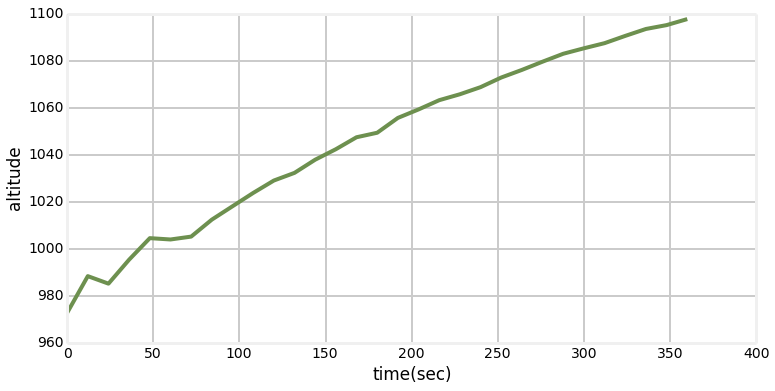

Actual altitude: 2561.9
UKF altitude   : 1097.9


In [18]:
# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100,0), 0.02)

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    if i >= 60:
        ac.vel[1] = 5 # 5 meters/second climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_radar(xs, t, plot_x=False, plot_vel=False, plot_alt=True)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

* The performance is terrible as the filter is completely unable to track the changing altitude. 
* Add climb rate to the state:


$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude \\ climb rate\end{bmatrix}=  \begin{bmatrix}x \\\dot{x}\\ z \\ \dot{z}\end{bmatrix}$$

This requires the following change to the state transition function, which is still linear.


$$\mathbf{x}^- = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&dt \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot{x}\\ z\\ \dot{z}\end{bmatrix} 
$$

* The measurement function stays the same, but we will have to alter Q to account for the state dimensionality change.

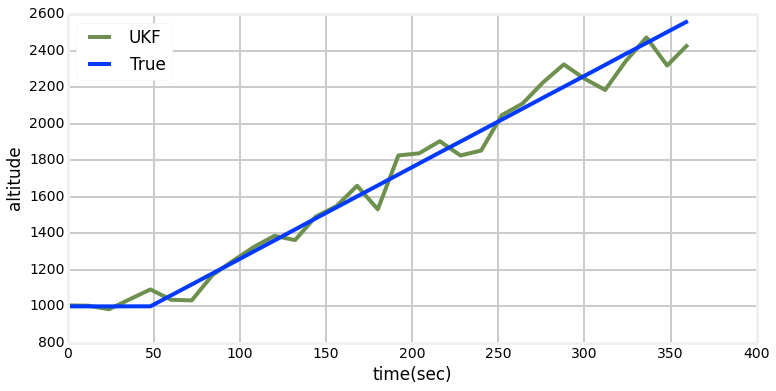

Actual altitude: 2561.9
UKF altitude   : 2432.9


In [19]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity aircraft"""
    
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return np.dot(F, x)

ac = ACSim(ac_pos, (100,0), 0.02)

kf = UKF(4, 2, dt, fx=f_cv_radar, hx=h_radar, kappa=-1)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
ac_alt = []
for i in t:
    if i >= 60:
        ac.vel[1] = 5 # 5 meters/second climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)
    ac_alt.append(ac.pos[1])

plt.figure()
xs = np.asarray(xs)
plt.plot(t, xs[:,2], label="UKF")
plt.plot(t, ac_alt, label="True")
plt.xlabel('time(sec)')
plt.ylabel('altitude')
plt.legend(loc='best')
plt.show()
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

* A significant amount of noise has been introduced into the altitude, but we are now accurately tracking the altitude change. 

### Sensor Fusion

* Consider a simple example of sensor fusion. 
* Suppose we have some type of Doppler system that produces a velocity estimate with 2 m/s RMS accuracy. 
* Degrade the accuracy of radar in order to easily see the effect of the sensor fusion.
    * Change the range error to 500 meters and then compute the standard deviation of the computed velocity. 

Velocity standard deviation 3.5 m/s


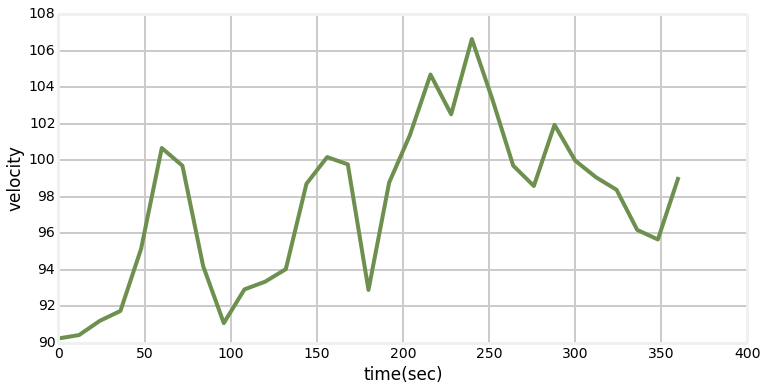

In [20]:
range_std = 500.
bearing_std = math.degrees(0.5)
radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)

ac = ACSim(ac_pos, (100,0), 0.02)
kf = UKF(4, 2, dt, fx=f_cv_radar, hx=h_radar, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

xs = np.asarray(xs)
plot_radar(xs, t, plot_x=False, plot_vel=True, plot_alt=False)
print('Velocity standard deviation {:.1f} m/s'.format(np.std(xs[10:,1])))

Velocity standard deviation 1.3 m/s


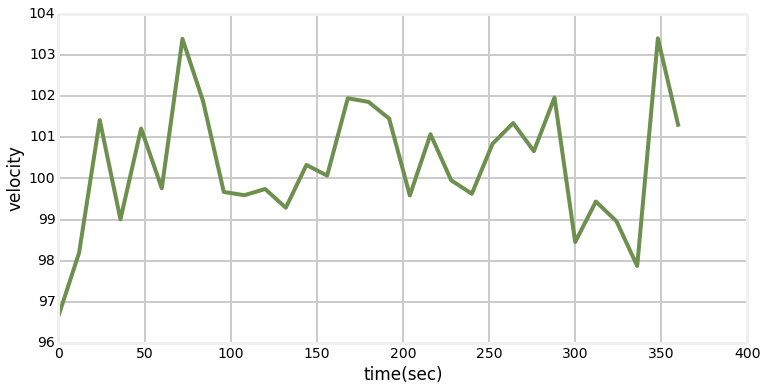

In [40]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    bearing = math.atan2(dz, dx)
    return slant_range, bearing, x[1], x[3]

h_vel.radar_pos = (0,0)

range_std = 500.
bearing_std = math.degrees(0.5)
radar = RadarStation(pos=(0,0), range_std=range_std, bearing_std=bearing_std)
vel_std = 2.

ac = ACSim(ac_pos, (100,0), 0.02)
kf = UKF(4, 4, dt, fx=f_cv_radar, hx=h_vel, kappa=0.)

kf.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4,2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2, vel_std**2, vel_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0,360+dt, dt)
n = len(t)

xs = []
for i in t:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf.predict()
    kf.update([r[0], r[1], vx, vz]) 
    xs.append(kf.x)
xs = np.asarray(xs)
plot_radar(xs, t, plot_x=False, plot_vel=True, plot_alt=False)
print('Velocity standard deviation {:.1f} m/s'.format(np.std(xs[10:,1])))

* By incorporating the velocity sensor we were able to reduce the standard deviation from 3.5 m/s to 1.3 m/s. 

### Multiple Position Sensors

* Before the advent of GPS ships and aircraft navigated via various range and bearing systems such as VOR, LORAN, TACAN, DME, and so on.  In general these systems are beacons that extract either the range, bearing, or range and bearing to the beacon. 
* For example, an aircraft might have two VOR (Very High Frequency Omnirange)) receivers. The pilot tunes each receiver to a different VOR station. Each VOR receiver displays what is called the "radial" - the direction from the VOR station on the ground to the aircraft. Using a chart they can extend these two radials - the intersection point is the position of the aircraft.
    * That is a very manual and low accuracy approach. We can use a Kalman filter to filter the data and produce far more accurate position estimates.

* Assume we have two sensors, each which provides a bearing only measurement to the target, as in the chart below. In the chart the width of the circle is intended to denote a different amount of sensor noise.

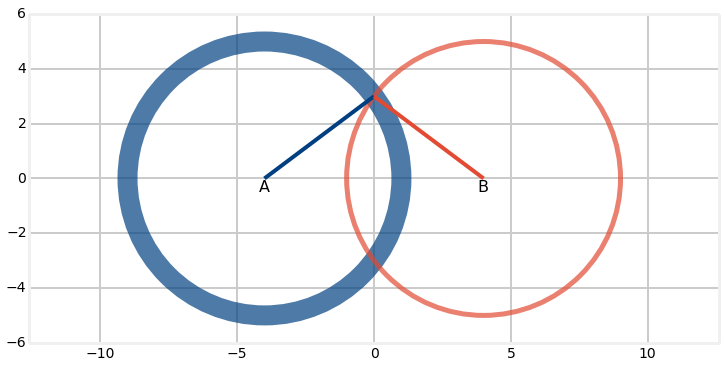

In [48]:
circle1=plt.Circle((-4,0),5,color='#004080',fill=False,linewidth=20, alpha=.7)
circle2=plt.Circle((4,0),5,color='#E24A33', fill=False, linewidth=5, alpha=.7)

fig = plt.gcf()
ax = fig.gca()

plt.axis('equal')
#plt.xlim((-10,10))
plt.ylim((-6,6))

plt.plot ([-4,0], [0,3], c='#004080')
plt.plot ([4,0], [0,3], c='#E24A33')
plt.text(-4, -.5, "A", fontsize=16, horizontalalignment='center')
plt.text(4, -.5, "B", fontsize=16, horizontalalignment='center')

ax.add_patch(circle1)
ax.add_patch(circle2)
plt.show()


* We can compute the bearing between a sensor and the target as follows:


    def bearing(sensor, target):
        return math.atan2(target[1] - sensor[1], target[0] - sensor[0])

* The filter will receive a vector of 2 measurements during each update, one for each sensor. We can implement that as:
 

    def measurement(A_pos, B_pos, pos):
        angle_a = bearing(A_pos, pos)
        angle_b = bearing(B_pos, pos)
        return [angle_a, angle_b]

* The design of the measurement function and state transition function can remain the same as nothing has changed that would affect them. 

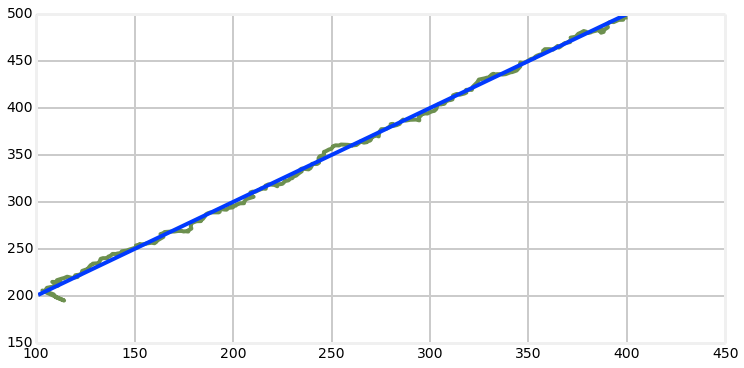

In [50]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise

sa_pos = [-400, 0]
sb_pos = [400, 0]


def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], target_pos[0] - sensor[0])

def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

def fx_VOR(x,dt):
    x[0] += x[1]
    x[2] += x[3]
    return x


def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)


def moving_target_filter(target_pos, std_noise, Q, dt=0.1, kappa=0.0):
    f = UKF(dim_x=4, dim_z=2, dt=dt, hx=hx_VOR, fx=fx_VOR, kappa=kappa)
    f.x = np.array([target_pos[0], 1., target_pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2,0:2] = q
    f.Q[2:4, 2:4] = q

    f.R *= std_noise**2
    f.P *= 1000
    
    return f


def plot_straight_line_target(f, std_noise):
    xs = []
    txs = []

    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:,0], xs[:,2])
    plt.plot(txs[:,0], txs[:,1])
    plt.show()
 
np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

* This looks quite good. There is a very large error at the beginning of the track, but the filter is able to settle down and start producing good data.

* Let's revisit the nonlinearity of the angles.
    * Positioning the target between the two sensors or on the left of them with the same y-coordinate will cause a nonlinearity in the computation of the sigma means and the residuals.
    * As the angle goes around $\pi$ 
        * The measurement reading will be a positive angle of around $\pi$ or a negtive angle of around $-\pi$. 
        * The mean angle (the prediction) will be near zero. 
    * The residual between the prediction and measurement will thus be nearly $\pi$ or $-\pi$ instead of nearly 0. This makes it impossible for the filter to perform accurately, as seen in the example below.

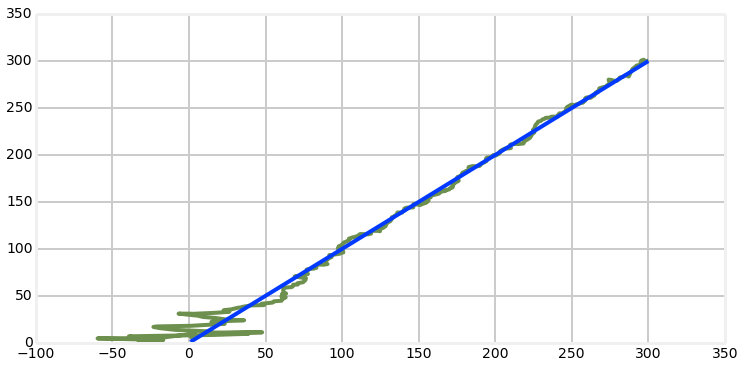

In [52]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

* This is untenable behavior for a real world filter. `FilterPy`'s UKF code allows to provide it a function to compute the residuals in cases of nonlinear behavior like this.


    def update(self, z, R=None, residual=np.subtract, UT=None):
        """ Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        **Parameters**

        z : numpy.array of shape (dim_z)
            measurement vector

        R : numpy.array((dim_z, dim_z)), optional
            Measurement noise. If provided, overrides self.R for
            this function call.

        residual : function (z, z2), optional
            Optional function that computes the residual (difference) between
            the two measurement vectors. If you do not provide this, then the
            built in minus operator will be used. You will normally want to use
            the built in unless your residual computation is nonlinear (for
            example, if they are angles)

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work, but if for example you are using angles the default method
            of computing means and residuals will not work, and you will have
            to define how to compute it.
        """


## Track a target moving in a circle

* Change the simulated target movement to move in a circle. Avoid angular nonlinearities by putting the sensors well outside the movement range of the target, and avoid the angles $0^\circ$ and $180^\circ$.

> If we know the movement of the target we can design our filter's state transition function so that it correctly predicts the circular movement. However, here we will not build knowledge of the movement into the filter.

In [26]:
def plot_circular_target(f, std_noise, target_pos):
    xs = []
    txs = []
    radius = 100
    for i in range(300):
        target_pos[0] = math.cos(i/10)*radius + randn()*0.0001
        target_pos[1] = math.sin(i/10)*radius + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:,0], xs[:,2])
    plt.plot(txs[:,0], txs[:,1], linestyle='-.')
    plt.axis('equal')
    plt.show()

sa_pos = [-240, 200]
sb_pos = [240, 200]

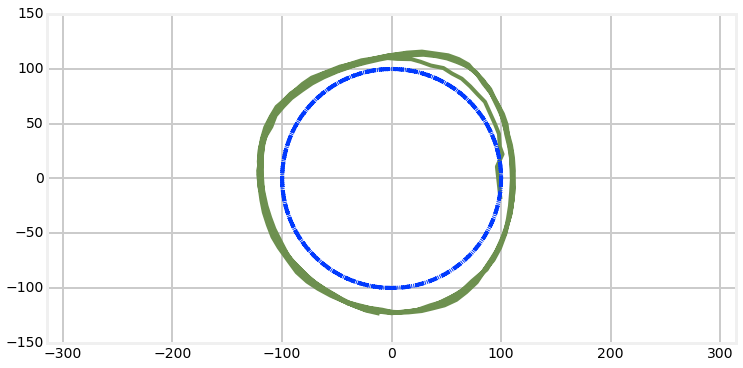

In [27]:
np.random.seed(12283)
std_noise = math.radians(0.5)
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.1)
plot_circular_target(f, std_noise, target_pos)

### Discussion

* The filter tracks the movement of the target, but never really converges on the track.
* This is because the filter is modeling a constant velocity target, but the target is anything but constant velocity.
* As mentioned above we could model the circular behavior by defining the `fx()` function, but then we would have problems when the target is not moving in a circle. 
* Instead, lets tell the filter we are are less sure about our process model by increasing $\mathbf{Q}$ from 0.1 to 1.0

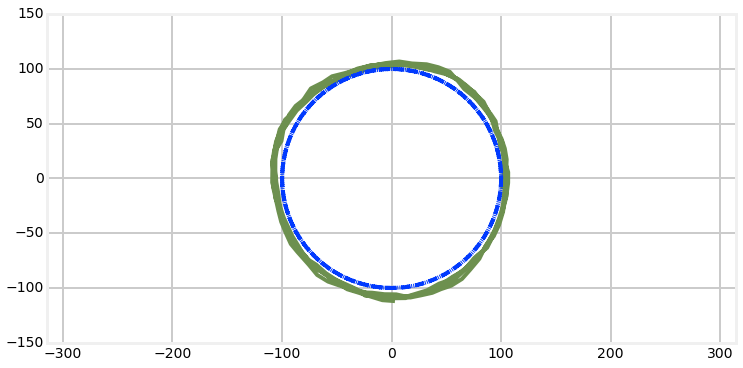

In [28]:
np.random.seed(12283)
std_noise = math.radians(0.5)
cf = moving_target_filter(target_pos, std_noise, Q=10.)
target_pos = [0, 0]
plot_circular_target(cf, std_noise, target_pos)

* The convergence is not perfect, but it is far better. 

## Compute Position Errors

The position errors of the filter vary depending on how far away the target is from a sensor. Write a function that computes the distance error due to a bearing error. 

In [21]:
def distance_error(target_distance, angle_error):
    x = 1-math.cos(angle_error)
    y = math.sin(angle_error)
    return target_distance*(x**2 + y**2)**.5

d = distance_error(100, math.radians(1.))
print('Error of 1 degree at 100km is {:.3}km'.format(d))

Error of 1 degree at 100km is 1.75km


### Discussion

* We can see that a very small angular error translates into a very large distance error.
* What is worse, this behavior is nonlinear - the error in the *x-axis* vs the *y-axis* will vary depending on the actual bearing. 
    * For example, here is a scatter plot that shows the error distribution for a $1^\circ$ standard deviation in bearing for a $30^\circ$ bearing.

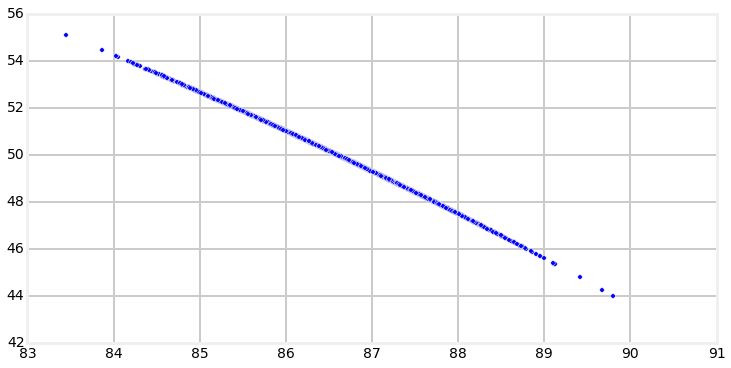

In [33]:
d = 100
xs, ys = [], []

for i in range (3000):
    a = math.radians(30) + randn() * math.radians(1)
    
    xs.append(d*math.cos(a))
    ys.append(d*math.sin(a))
    
plt.scatter(xs, ys)
plt.show() 

## Explain Filter Performance

We can see that for even very small angular errors the (x, y) positional errors are very large. Explain how we got such relatively good performance out of the UKF in the target tracking problems above.

* There are several factors contributing to the success.
* First, let's consider the case of having only one sensor.
    * Any single measurement has an extreme range of possible positions. But, our target is moving, and the UKF is taking that into account.
    * Let's plot the results of several measurements taken in a row for a moving target to form an intuition.

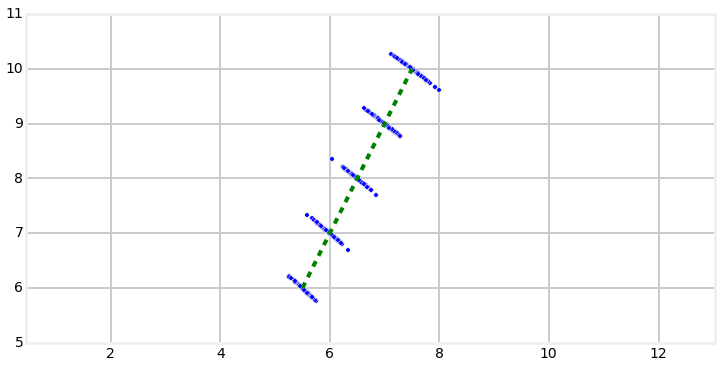

In [34]:
pos = [5, 5]
for i in range(5):
    pos[0] += 0.5
    pos[1] += 1  
    
    actual_angle = math.atan2(pos[1], pos[0])
    d = math.sqrt(pos[0]**2 + pos[1]**2)

    xs, ys = [], []
    for i in range (100):
        a = actual_angle + randn() * math.radians(1)
        xs.append(d*math.cos(a))
        ys.append(d*math.sin(a))
    plt.scatter(xs, ys)

plt.axis('equal')
plt.plot([5.5, pos[0]], [6, pos[1]], c='g', linestyle='--')
plt.show()

* Each individual measurement has a very large position error. However, when we plot successive measurements we suddenly have a clear trend - the target is obviously moving towards the upper right.
* When a Kalman filter computes the Kalman gain it takes the distribution of errors into account by using the measurement function.
    * In this example the error lies on an approximately $45^\circ$ degree line, so the filter will discount errors in that direction.
    * On the other hand, there is almost no error in measurement orthogonal to that, and again the Kalman gain will be taking that into account.
    * The end result is the track can be computed even with this sort of noise distribution.
* This graph makes it easy to see where the target is moving because we have computed 100 possible measurements for each position update and plotted them all. In contrast, the Kalman filter only gets 1 measurement per update. Therefore the filter will not be able to generate as good a fit as the dotted green line implies. 

Now let's consider the effect of adding a second sensor. Again, start by plotting the measurements so we can form an intuition about the problem.

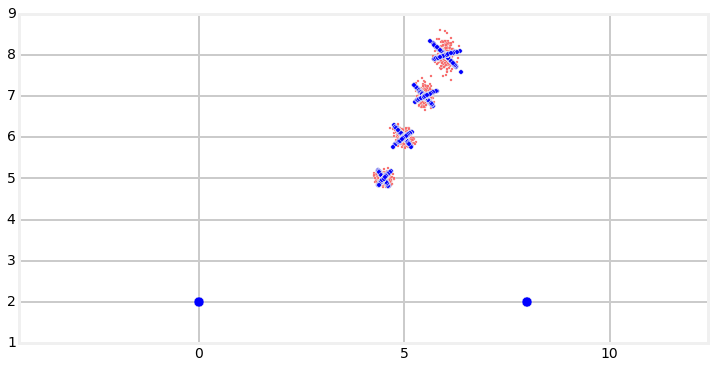

In [35]:
from math import sin, cos, atan2, pi

def isct(pa, pb, alpha, beta):
    """ Returns the (x, y) intersections of points pa and pb
    given the bearing ba for point pa and bearing bb for
    point pb.
    """
    
    B = [pb[0] - pa[0], pb[1]- pa[1]]

    AB = math.sqrt((pa[0]-pb[0])**2 + (pa[1] - pb[1])**2) 
    
    ab = atan2(B[1], B[0])
    a = alpha - ab    
    b = pi - beta - ab
    p = pi - b - a
    
    AP = (sin(b) / sin(p)) * AB
    
    x = cos(alpha) * AP + pa[0]
    y = sin(alpha) * AP + pa[1]
    return x, y


def plot_iscts(N=4):
    for i in range(N):
        pos[0] += 0.5
        pos[1] += 1  

        actual_angle_a = math.atan2(pos[1]-sa[1], pos[0] - sa[0])
        actual_angle_b = math.atan2(pos[1]-sb[1], pos[0] - sb[0])

        da = math.sqrt((sa[0]-pos[0])**2 + (sa[1]-pos[1])**2)
        db = math.sqrt((sb[0]-pos[0])**2 + (sb[1]-pos[1])**2)

        xs, ys, xs_a, xs_b, ys_a, ys_b = [], [], [], [], [], []

        for i in range (300):
            a_a = actual_angle_a + randn() * math.radians(1)
            a_b = actual_angle_b + randn() * math.radians(1)

            x,y = isct(sa, sb, a_a, a_b)
            xs.append(x)
            ys.append(y)

            xs_a.append(da*math.cos(a_a)+sa[0])
            ys_a.append(da*math.sin(a_a)+sa[1])

            xs_b.append(db*math.cos(a_b)+sb[0])
            ys_b.append(db*math.sin(a_b)+sb[1])

        plt.scatter(xs, ys, c='r', marker='.')
        plt.scatter(xs_a, ys_a)
        plt.scatter(xs_b, ys_b)

    plt.axis('equal')
    plt.show()

pos = [4, 4]
sa = [0, 2]
sb = [8, 2]

plt.scatter(*sa, s=100)
plt.scatter(*sb, s=100)
plot_iscts(N=4)

* The sensors are placed nearly orthogonal to the target's initial position so we get these lovely 'x' shape intersections.
* Then computed the (x, y) coordinate corresponding to the two noisy bearing measurements and plotted them with red dots to show the distribution of the noisy measurements in x and y.
    * We can see how the errors in x and y change as the target moves by the shape the scattered red dots make - as the target gets further away from the sensors, but nearer the y coordinate of sensor B the shape becomes strongly elliptical.

Next alter the starting positions and rerun the simulation. Here the shape of the errors in x and y changes radically as the target position changes relative to the two sensors. 

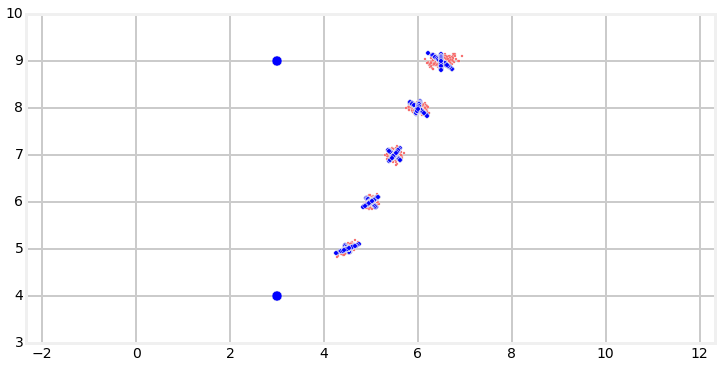

In [36]:
sa = [3, 4]
sb = [3, 9]
pos= [4, 4]

plt.scatter(*sa, s=100)
plt.scatter(*sb, s=100)
plot_iscts(N=5)

## Visualize Sigma Points

* Use the UKF to generate sigma points and pass them through the nonlinear function, and plot the sigma points and their mean against the 5,000 points.
    * Pass the points through the state transition function:

$$\mathbf{Fx} = \begin{bmatrix}1 & 1 \\ .1x &y\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix}$$ 

for the mean $$\mu = \begin{bmatrix}0\\0\end{bmatrix}$$ and the covariance
$$\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

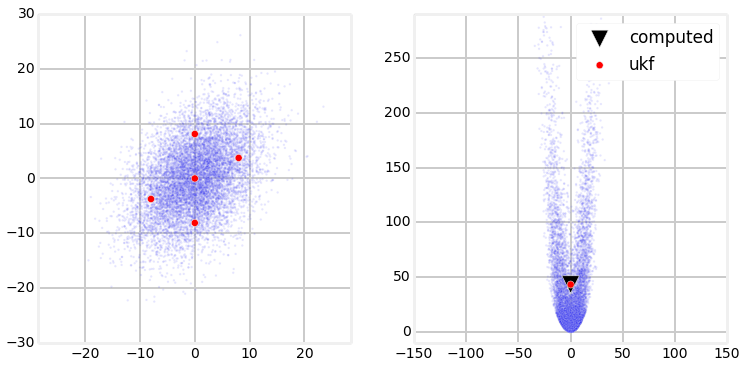

Difference in mean x=-0.040, y=0.020


In [55]:
from filterpy.kalman import unscented_transform

def f_nonlinear_xy(x,y):
    return np.array([x+y, .1*x**2 +y*y])

mean = (0, 0)
p = np.array([[32., 15],
              [15., 40.]])


### compute mean via UKF
kappa = 0.
w = UKF.weights(2, kappa)
sigmas = UKF.sigma_points(mean, p, kappa)
sigmas_f = np.zeros((5,2))
for i in range(5):
        sigmas_f[i] = f_nonlinear_xy(sigmas[i,0], sigmas[i,1])
  

ukf_mean, _ = unscented_transform(sigmas_f, w, w, np.zeros((2,2)))

# generate 50000 points to compute accurate mean
np.random.seed(73291)
xs ,ys = multivariate_normal(mean=mean, cov=p, size=50000).T
fxs, fys = [], []
for x,y in zip(xs,ys):
    fx, fy = f_nonlinear_xy(x,y)
    
    fxs.append(fx)
    fys.append(fy)

computed_mean_x = np.average(fxs)
computed_mean_y = np.average(fys)


plt.subplot(121)
plt.scatter (xs[0:10000], ys[0:10000], marker='.', alpha=0.1)
plt.scatter(sigmas[:,0], sigmas[:,1], c='r',s=50)
plt.axis('equal')

plt.subplot(122)
plt.scatter(fxs[0:10000], fys[0:10000], marker='.', alpha=0.1)
plt.scatter(computed_mean_x, computed_mean_y, 
            marker='v',s=300,c='k', label='computed')
plt.scatter(ukf_mean[0], ukf_mean[1], 
            marker='o', s=50, c='r', label='ukf')
plt.ylim([-10,290])
plt.xlim([-150,150])
plt.legend(loc='best', scatterpoints=1)
plt.show()
print ('Difference in mean x={:.3f}, y={:.3f}'.format(
       computed_mean_x-ukf_mean[0], computed_mean_y-ukf_mean[1]))

### Discussion

* The first exercise had an error of roughly 43 in the y axis, whereas with 50,000 points simulated the UKF has an error of around 0.02. 

## Implementation of the UKF

It is instructive to learn how to go from equations to code. Plus, if you encounter a problem and need to debug your code you will likely need to step through the code with the debugger.

* Compute the mean and covariance given the sigma points. 
    * Store the sigma points and weights in matrices


$$ 
\begin{aligned}
weights &= 
\begin{bmatrix}
w_1&w_2& \dots & w_{2n+1}
\end{bmatrix} 
\\
sigmas &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} &  \mathcal{X}_{0,2n+1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \mathcal{X}_{1,2n+1} \\
\vdots & \vdots & \vdots \\
\mathcal{X}_{D-1,0} & \mathcal{X}_{D-1,1} & \mathcal{X}_{D-1,2n+1}
\end{bmatrix}
\end{aligned}
$$

Each column contains the $2n+1$ sigma points for one dimension.
* The $0th$ sigma point is always the mean, so first row of sigma's contains the mean of each of our dimensions. 
* The second through nth row contains the $\mu+\sqrt{(n+\lambda)\Sigma}$ terms, and the $n+1$ to $2n$ rows contains the $\mu-\sqrt{(n+\lambda)\Sigma}$ terms. 
    * Refer to the ith sigma point for all dimensions as `sigmas[i]`.

### Weights

* Recall that for the Julier implementation

$$
\begin{aligned}
W_0 &= \frac{\kappa}{n+\kappa} \\
W_i &= \frac{1}{2(n+\kappa)}\,\,\,\text{for i=1,2..2n}
\end{aligned}
$$

* The `np.full()` method creates and fills an array with the same value. Then the value for the mean($W_0$) is computed and overwrites the filled in value. 

    W = np.full((2*n+1,1), .5 / (n+kappa))
    W[0] = kappa / (n+kappa)

In [39]:
def weights(n, kappa):
    """ Computes the weights for an unscented Kalman filter. """

    k = .5 / (n+kappa)
    W = np.full(2*n+1, k)
    W[0] = kappa / (n+kappa)
    return W

### Sigma Points

The equations for the sigma points are:

$$
\begin{aligned}
\mathcal{X}_0 &= \mu \\
\mathcal{X}_i &= \mu +  \bigg[\sqrt{(n+\kappa)\Sigma}  \bigg]_i\,\,\,\, &\text{for}\text{ i=1 .. n} \\
\mathcal{X}_i &= \mu - \bigg[\sqrt{(n+\kappa)\Sigma}\bigg]_{i-n}\,\,\,\,\, &\text{for}\text{ i=(n+1) .. 2n}
\end{aligned}
$$

The term $[\sqrt{(n+\kappa)\Sigma}]_i$ has to be a matrix because $\Sigma$ is a matrix. The subscript $i$ is choosing the column vector of the matrix. What is the 'square root of a matrix'? The usual definition is that the square root of a matrix $\Sigma$ is just the matrix $S$ that, when multiplied by itself, yields $\Sigma$.

$$
\begin{aligned}
\text{if }\Sigma = SS^T \\
\\
\text{then }S = \sqrt{\Sigma}
\end{aligned}
$$

However there is an alternative definition, and we will chose that because it has numerical properties that makes it much easier for us to compute its value. We can alternatively define the square root as the matrix S, which when multiplied by its transpose, returns $\Sigma$:

$$
\Sigma = SS^\mathsf{T} \\
$$

This latter method is typically chosen in computational linear algebra because this expression is easy to compute using something called the *Cholesky decomposition* [3]. 
NumPy provides this with the `numpy.linalg.cholesky()` method.  Matlab provides `chol()`, which does the same thing.

This method returns a lower triangular matrix, so we will take the transpose of it so that in our for loop we can access it row-wise as `U[i]`, rather than the more cumbersome column-wise notation `U[i,:]`.

    Sigmas = np.zeros((2*n+1, n))
    U = linalg.cholesky((n+kappa)*P).T

    for k in range (n):
        Sigmas[k+1]   = X + U[k]
        Sigmas[n+k+1] = X - U[k]

    Sigmas[0] = X

Now let's implement the unscented transform. Recall the equations
$$\begin{aligned}
\mu &= \sum_i w_i\mathcal{X}_i\;\;\;&(2) \\
\Sigma &= \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}\;\;\;&(3)
\end{aligned}
$$

The UKF can use different weights for the means and covariance, the variable `Wm` for the mean weights and `Wc` for the covariance weights.

We implement the sum of the means with

    X = np.dot (Wm, Sigmas)

> NumPy is written in C to achieve much faster speeds than Python can reach. To get that speedup we must avoid using for loops, and instead use NumPy's built in functions to perform calculations. So, instead of writing a for loop to compute the sum, it is better to call the built in numpy.dot(x,y) method.

All that is left is to compute $\mathbf{P} = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf{Q}$

    kmax, n = Sigmas.shape
    P = zeros((n, n))
    for k in range(kmax):
        y = Sigmas[k] - x
        P += Wc[k] * np.outer(y, y) 
    P += Q

This introduces another feature of NumPy. The state variable $X$ is one dimensional, as is $Xi[k]$, so the difference $Xi[k]-X$ is also one dimensional. NumPy will not compute the transpose of a 1-D array; it considers the transpose of `[1,2,3]` to be `[1,2,3]`. So we call the function `np.outer(y,y)` which computes the value of $yy^\mathsf{T}$ for a 1D array $y$.

The `sigma_points` function can be implemented as below

In [41]:
def sigma_points(x, P, kappa):
    """ Computes the sigma pointsfor an unscented Kalman filter
    given the mean (x) and covariance(P) of the filter.
    kappa is an arbitrary constant. Returns tuple of the sigma points
    and weights.

    Works with both scalar and array inputs:
    sigma_points (5, 9, 2) # mean 5, covariance 9
    sigma_points ([5, 2], 9*eye(2), 2) # means 5 and 2, covariance 9I

    **Parameters**

    X An array-like object of the means of length n
        Can be a scalar if 1D.
        examples: 1, [1,2], np.array([1,2])

    P : scalar, or np.array
       Covariance of the filter. If scalar, is treated as eye(n)*P.

    kappa : float
        Scaling factor.

    **Returns**

    sigmas : np.array, of size (n, 2n+1)
        2D array of sigma points. Each column contains all of
        the sigmas for one dimension in the problem space. They
        are ordered as:

        .. math::
            sigmas[0]    = x \n
            sigmas[1..n] = x + [\sqrt{(n+\kappa)P}]_k \n
            sigmas[n+1..2n] = x - [\sqrt{(n+\kappa)P}]_k
    """

    if np.isscalar(x):
        x = asarray([x])
    n = np.size(x)  # dimension of problem

    if  np.isscalar(P):
        P = eye(n)*P

    Sigmas = zeros((2*n+1, n))

    # implements U'*U = (n+kappa)*P. Returns lower triangular matrix.
    # Take transpose so we can access with U[i]
    U = cholesky((n+kappa)*P).T
    #U = sqrtm((n+kappa)*P).T

    for k in range(n):
        Sigmas[k+1]   = x + U[k]
        Sigmas[n+k+1] = x - U[k]

    # handle value for the mean separately as special case
    Sigmas[0] = x

    return Sigmas

### Predict Step

For the predict step, we will generate the weights and sigma points as specified above. We pass each sigma point through the function f.

$$\mathcal{X_f} = f(\mathcal{X})$$

Then we compute the predicted mean and covariance using the unscented transform. In the code below you can see that I am assuming that this is a method in a class that stores the various matrices and vectors needed by the filter.

In [42]:
def predict(self):
    """ Performs the predict step of the UKF. On return, self.xp and
    self.Pp contain the predicted state (xp) and covariance (Pp). 'p'
    stands for prediction.

    Important: this MUST be called before update() is called for the first
    time.
    """

    # calculate sigma points for given mean and covariance
    sigmas = self.sigma_points(self.x, self.P, self.kappa)

    for i in range(self._num_sigmas):
        self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

    self.xp, self.Pp = unscented_transform(
                       self.sigmas_f, self.W, self.W, self.Q)

### Update Step

The update step converts the sigmas into measurement space via the `h(x)` function.


$$\mathcal{X_z} = h(\mathcal{X_f})$$

The mean an covariance of those points is computed with the  unscented transform. The residual and Kalman gain is then computed. The cross variance is computed as:


$$\mathbf{P}_{xz} =\sum W(\mathcal{X}-x)(\mathcal{X_z}-\mathbf{x}_z)^\mathsf{T}$$


Finally, we compute the new state estimate using the residual and Kalman gain:

$$\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf{P} = \mathbf{P}^- - \mathbf{PKP}_z\mathbf{K}^\mathsf{T}$$

This function can be implemented as follows, assuming it is a method of a class that stores the necessary matrices and data.

In [43]:
def update(self, z):
    """ Update the UKF with the given measurements. On return,
    self.x and self.P contain the new mean and covariance of the filter.

    **Parameters**

    z : numpy.array of shape (dim_z)
        measurement vector
    """

    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through inscented transform
    zp, Pz = unscented_transform(sigmas_h, self.W, self.W, self.R)

    # compute cross variance of the state and the measurements
    Pxz = zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.W[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + dot(K, z-zp)
    self.P = self.Pp - dot3(K, Pz, K.T)

## Choosing Values for kappa

* The literature on choosing values for $\kappa$ is rather lacking.
* Julier's original paper suggests a value of $n+\kappa=3$ if the distribution is Gaussian, and if not a "different choice of $\kappa$ might be more appropriate". He also describes it as a "fine tuning" parameter. 

So let's just explore what it does. Let $n=1$ just to minimize the size of the arrays we need to look at.

In [48]:
def print_sigmas(n=1, mean=5, cov=3, kappa=2):
    print('sigmas: ', UKF.sigma_points(mean,  cov, kappa).T[0])
    print('weights:', UKF.weights(n, kappa))
    
print_sigmas(mean=0, cov=3, kappa=2)

sigmas:  [ 0.  3. -3.]
weights: [ 0.6667  0.1667  0.1667]


* For a mean of 0 the algorithm choose sigma points of 0, 3, and -3, but why? Recall the equation for computing the sigma points:

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\kappa)\Sigma}
\end{aligned}$$

Here $n=1$ reduces everything to scalars, allowing us to avoid computing the square root of matrices. So, for our values the equation is

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= 0 \pm \sqrt{9} \\
&= \pm 3
\end{aligned}$$

So as $\kappa$ gets larger the sigma points get more spread out. Let's set it to an absurd value.

In [49]:
print_sigmas(mean=0, cov=3, kappa=200)

sigmas:  [  0.      24.5561 -24.5561]
weights: [ 0.995   0.0025  0.0025]


* The sigma point spread starts to be dominated by $\kappa$ ($\sqrt{200*3}$). Here $k+n=201$ instead of the $k+n=3$ suggested by Julier. 
    * If our data was Gaussian we'd be incorporating data many standard deviations away from the mean; for nonlinear problems this is unlikely to produce good results. 
    * Suppose our distribution was not Gaussian, instead had very fat tails. We might need to sample from those tails to get a good estimate, and hence it would make sense to make $kappa$ larger.
    * Suppose that our distribution has nearly no tails - the probability distribution looks more like an inverted parabola. In such a case we'd probably want to pull the sigma points in closer to the mean to avoid sampling in regions where there will never be real data.

Now let's look at the change in the weights. 

* When we have $k+n=3$ the weights were 0.6667 for the mean, and 0.1667 for the two outlying sigma points.
* On the other hand, when $\kappa=200$ the mean weight shot up to 0.995 and the outlier weights were set to 0.0025. Recall the equations for the weights:

$$\begin{aligned}
W_0 &= \frac{\kappa}{n+\kappa} \\
W_i &= \frac{1}{2(n+\kappa)}
\end{aligned}$$

We can see that 

* As $\kappa$ gets larger the fraction for the weight of the mean ($\kappa/(n+\kappa)$) approaches 1, and the fraction for the weights of the rest of the sigma points approaches 0.
* This is invariant on the size of the covariance. 
* So as we sample further and further away from the mean we end up giving less weight to those samples, and if we sampled very close to the mean we'd give very similar weights to all.